# Imports and config

Run this first to setup the notebook.

In [ ]:
# install and import

!pip install nilearn --quiet
import os
import numpy as np
import matplotlib.pyplot as plt
import os, requests, tarfile
import pandas as pd

# Necessary for visualization
from nilearn import plotting, datasets
from nilearn.surface import vol_to_surf

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./DATA"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# filepaths for convinience
fpath_task = os.path.join(HCP_DIR, "hcp_task")
fpath_rest = os.path.join(HCP_DIR, "hcp_rest")

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 29.8 MB/s eta 0:00:00


# Put functions here

If you make a couple of lines of code that does something, it's good to wrap it in a function so that it can be re-used elsewhere. Let's put all of our functions here so that the actual analysis is as clean and readable as possible. Remember to add [docstrings](https://www.datacamp.com/tutorial/docstrings-python) to your functions so we can use them without looking at source code!

In [ ]:
def download_data():
  """Download the HCP dataset."""

  fnames = ["hcp_rest.tgz",
            "hcp_task.tgz",
            "hcp_covariates.tgz",
            "atlas.npz"]
  urls = ["https://osf.io/bqp7m/download",
          "https://osf.io/s4h8j/download",
          "https://osf.io/x5p4g/download",
          "https://osf.io/j5kuc/download"]


  for fname, url in zip(fnames, urls):
    if not os.path.isfile(fname):
      try:
        r = requests.get(url)
      except requests.ConnectionError:
        print("!!! Failed to download data !!!")
      else:
        if r.status_code != requests.codes.ok:
          print("!!! Failed to download data !!!")
        else:
          print(f"Downloading {fname}...")
          with open(fname, "wb") as fid:
            fid.write(r.content)
          print(f"Download {fname} completed!")


  fnames = ["hcp_covariates", "hcp_rest", "hcp_task"]

  for fname in fnames:
    # open file
    path_name = os.path.join(HCP_DIR, fname)
    if not os.path.exists(path_name):
      print(f"Extracting {fname}.tgz...")
      with tarfile.open(f"{fname}.tgz") as fzip:
        fzip.extractall(HCP_DIR)
    else:
      print(f"File {fname}.tgz has already been extracted.")


def load_regions_and_atlas():
  """Load region info and parcellations.

    Args:
      None
    Returns:
      Tuple containing:
        region_info (dict): region names and network assignments
        atlas (dict): parcellation on the fsaverage5 surface and approximate MNI coordinates of each region
  """
  folder = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
  regions = np.load(os.path.join(folder, "regions.npy")).T
  region_info = dict(name=regions[0].tolist(),
                    network=regions[1],
                    myelin=regions[2].astype(float)
                    )
  with np.load(f"atlas.npz") as dobj:
    atlas = dict(**dobj)

  return region_info, atlas


def read_behavior_data(kind, output_type="pandas"):
    """Read behavior data from HCP dataset.

    Args:
        kind (str): "gambling", "language", "emotion", "relational", "social" or "wm",
        output_type (str): Sets the output dataframe format. Can be "numpy" or "pandas". Default is "pandas".
    Returns:
         wm_behavior (np.ndarray or pandas DataFrame): behavior data
    """
    fpath = os.path.join(HCP_DIR, "hcp", "behavior", f"{kind}.csv")

    if output_type == "numpy":
        wm_behavior = np.genfromtxt(fpath,
                                delimiter=",",
                                names=True,
                                dtype=None,
                                encoding="utf")

    elif output_type == "pandas":
        import pandas as pd
        wm_behavior = pd.read_csv(fpath)

    return wm_behavior


def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data


def seconds_to_samples(sec):
  """Converts seconds to samples (multiply by TR and floor).
  Args:
    sec (float): time in seconds
  Return:
    samples (int): time in samples
    """
  return int(sec * TR)


def get_conds(subject, task, conds, concat=False, skip=0):
    """Get timeseries for conditions of interest.
    Args:
    subject (int): subject id,
    task (string): task id ("wm", "gambling" etc.)
    conds (list): list of conditions to concatenate.
    concat (bool): If true, concatenate conditions instead of making a list.
    skip (int):  Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    Returns:
    ndarray (n_parcel x n_tp array) or list of ndarrays: Array of concatenated BOLD data values or a list of (not concatenated) data values.
    """
    # load subject timeseries
    ts = load_timeseries(subject, task, fpath_task)

    cuts = []
    # for each condition
    for cond in conds:
        # load evs
        evs = load_evs(subject, task, cond, fpath_task)

        # indexing array
        frames = condition_frames(evs, skip=skip)

        # for each run
        for run in range(len(frames)):

            # cut
            ts_cut = ts[:, frames[run]]

            # append to cuts list
            cuts.append(ts_cut)


    # Optionally concatenate in time
    if concat:
        cuts = np.concatenate(cuts, axis=-1)

    return cuts


def extract_frontoparietal_parcels(two_back, no_back, region_info):
    """
    Extracts the Frontoparietal network parcels from two_back and no_back datasets.

    Parameters:
    - two_back: List of NumPy arrays, each representing the time series data for a participant
                during the two-back task with shape (regions:360, subjects:399).
    - no_back: List of NumPy arrays, each representing the time series data for a participant
                during the no-back task with shape (regions:360, subjects:399).
    - region_info: A dictionary containing region metadata, including network assignments.

    Returns:
    - two_back_fpn: List of NumPy arrays containing only the Frontoparietal network parcels
                     from the two_back dataset. (subjetcs: 339, parcels: 50, timepoints:152)
    - no_back_fpn: List of NumPy arrays containing only the Frontoparietal network parcels
                    from the no_back dataset. (subjetcs: 339, parcels: 50, timepoints:152)
    """
    # Identify the indices of the 'Frontopariet' network
    fpn_network_name = "Frontopariet"
    fpn_indices = [i for i, network in enumerate(region_info['network']) if network == fpn_network_name]

    two_back_fpn = []
    no_back_fpn = []

    # Extract Frontopariet parcels for two_back
    for subject_two_back in two_back:
        frontopariet_two_back = subject_two_back[fpn_indices, :]  # Assuming subject_two_back is a numpy array
        two_back_fpn.append(frontopariet_two_back)

    # Extract Frontopariet parcels for no_back
    for subject_no_back in no_back:
        frontopariet_no_back = subject_no_back[fpn_indices, :]  # Assuming subject_no_back is a numpy array
        no_back_fpn.append(frontopariet_no_back)

    return two_back_fpn, no_back_fpn

def get_cond_onsets(num_subjects, conditions, fpath_task):
    """
    Extracts the onsets of each condition of each subject

    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - fpath_task: path to the event info

    Returns:
    - Onsets: pandas dataframe containing the onset time per condition,
        separated for each run (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.))
    """
    # Initialize an empty DataFrame with NaN values
    Onsets = pd.DataFrame(index=[f'{i}' for i in range(num_subjects)])

    # Fill the DataFrame with tuples of onset values
    for subject_id in range(num_subjects):
        for cond in conditions:
            ev =load_evs(subject_id, "wm", cond, dir=fpath_task)
            onset_values = [ev[0]['onset'],ev[1]['onset']]
            Onsets.at[f'{subject_id}', f'{cond}_run0'] = onset_values[0]
            Onsets.at[f'{subject_id}', f'{cond}_run1'] = onset_values[1]

    return Onsets

def get_cond_timeseries(num_subjects, conditions, fpath_task, Onsets):
    """
    Extracts the timeseries of each condition of each subject (360 ROI * 38 or 39 timepoints)

    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - fpath_task: path to the event info

    Returns:
    - TimeSeries: pandas dataframe containing the timeseries per condition, separated for each run
        (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.)),
        each cell of the pd dataframe contains the timeseries of all 360 ROIs
    """
    # Initialize an empty DataFrame with NaN values
    TimeSeries = pd.DataFrame(index=[f'{i}' for i in range(num_subjects)],columns=Onsets.columns)

    # Fill the DataFrame with tuples of timeseries values
    for subject_id in range(num_subjects):
        TS =load_timeseries(subject_id, "wm", concat=False, remove_mean=True, dir=fpath_task) # get timeseries from both runs
        for cond in conditions:
            for run in range(1):
                onset_values = [Onsets.at[f'{subject_id}', f'{cond}_run0'],Onsets.at[f'{subject_id}', f'{cond}_run1']]
                timeframe0=[int(np.floor(onset_values[0]/TR)),int(np.floor((onset_values[0]+27.5)/TR))] # 27.5 = duration in seconds
                timeframe1=[int(np.floor(onset_values[1]/TR)),int(np.floor((onset_values[1]+27.5)/TR))]
                ts_pd1=pd.DataFrame(index=[str(i) for i in range(360)], columns=[str(i) for i in range(timeframe0[1]-timeframe0[0])]) # rows=ROIs, columns=slices
                ts_pd1.iloc[:, :] = TS[0][:,timeframe0[0]:timeframe0[1]]
                ts_pd2=pd.DataFrame(index=[str(i) for i in range(360)], columns=[str(i) for i in range(timeframe1[1]-timeframe1[0])])
                ts_pd2.iloc[:, :] = TS[1][:,timeframe1[0]:timeframe1[1]]
                TimeSeries.at[f'{subject_id}', f'{cond}_run0'] = ts_pd1
                TimeSeries.at[f'{subject_id}', f'{cond}_run1'] = ts_pd2

    return TimeSeries

In [ ]:
import inspect
# Get a list of all functions defined above
function_list = [name for name, obj in globals().items() if inspect.isfunction(obj)]

# Print the list of function names
for func_name in function_list:
    print(func_name)

vol_to_surf
download_data
load_regions_and_atlas
read_behavior_data
get_image_ids
load_timeseries
load_single_timeseries
load_evs
condition_frames
selective_average
seconds_to_samples
get_conds
extract_frontoparietal_parcels
get_cond_onsets
get_cond_timeseries


# Condition info

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools,
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

# Run stuff

In [ ]:
# always start with downloading data
download_data()

Download hcp_rest.tgz completed!
Download hcp_task.tgz completed!
Download hcp_covariates.tgz completed!
Download atlas.npz completed!
Extracting hcp_covariates.tgz...
Extracting hcp_rest.tgz...
Extracting hcp_task.tgz...


In [ ]:
# Some example functions

region_info, atlas = load_regions_and_atlas()

emo_behavior = read_behavior_data("emotion")

## Region Info & Atlas Exploratory work

In [ ]:
help(load_regions_and_atlas)

Help on function load_regions_and_atlas in module __main__:

load_regions_and_atlas()
    Load region info and parcellations.
    
    Args:
      None
    Returns:
      Tuple containing:
        region_info (dict): region names and network assignments
        atlas (dict): parcellation on the fsaverage5 surface and approximate MNI coordinates of each region



In [ ]:
region_info, atlas = load_regions_and_atlas()

**Region Info Expl. Work**

In [ ]:
#make the region info a pd.data frame
region_info_pd = pd.DataFrame(region_info)
region_info_pd.head(5)

,name,network,myelin
0,R_V1,Visual1,2.20900
1,R_MST,Visual2,2.05561
2,R_V6,Visual2,2.14980
3,R_V2,Visual2,2.15347
4,R_V3,Visual2,2.07251


In [ ]:
atlas

{'labels_R': array([ 54, 116,  50, ..., 134, 134, 134], dtype=int32),
 'labels_L': array([233, 228, 220, ..., 301, 301, 306], dtype=int32),
 'coords': array([[ 13.88705062, -79.36989109,   2.95539586],
        [ 43.31077929, -65.46435175,   3.65888316],
        [ 17.07818631, -76.27357601,  28.4532264 ],
        ...,
        [-43.66333418,  -6.4398113 , -15.54653597],
        [-10.61476522,  29.20779575,  26.91586381],
        [ -4.58484419,  34.61082077,  15.00143417]])}

In [ ]:
#classic exploratory work
region_info_pd['network'].value_counts()


network
Posterior-Mu    77
Cingulo-Oper    56
Visual2         54
Frontopariet    50
Somatomotor     39
Language        23
Default         23
Auditory        15
Dorsal-atten     7
Visual1          6
Orbito-Affec     6
Ventral-Mult     4
Name: count, dtype: int64

**Atlas Exploratory Work**

In [ ]:
#Transofrming atlas directly to a pd.DataFrame gives me an error, let's inspect why.

print(type(atlas))

for key, value in atlas.items():
  print(f"{key}: {type(value)} - {value}")

#It gives an error because it is a multidimensional array in coords.
print("atlas[\"labels_R\"].shape:", atlas["labels_L"].shape)
print("atlas[\"labels_L\"].shape:", atlas["labels_L"].shape)
print("atlas[\"coords\"].shape:", atlas["coords"].shape)

# Indeed coords has shape (360, 3). Let's unpack it to transofrm it into a pd.DataFrame for comodity later.
# Probably coords corresponds to coordinates, and the fact that it has three dimensions means x, y, z.
# So let's unpack it into these three.

coords = pd.DataFrame(atlas['coords'], columns=['x', 'y', 'z'])

#Let's also create two DataFrames for the other labels

labels = pd.DataFrame({
    'labels_R': atlas['labels_R'],
    'labels_L': atlas['labels_L']
})

# Let's then concatenate and form a final pd.DataFrame

atlas_pd = pd.concat([labels, coords], axis=1)

atlas_pd.describe()

<class 'dict'>
labels_R: <class 'numpy.ndarray'> - [ 54 116  50 ... 134 134 134]
labels_L: <class 'numpy.ndarray'> - [233 228 220 ... 301 301 306]
coords: <class 'numpy.ndarray'> - [[ 13.88705062 -79.36989109   2.95539586]
 [ 43.31077929 -65.46435175   3.65888316]
 [ 17.07818631 -76.27357601  28.4532264 ]
 ...
 [-43.66333418  -6.4398113  -15.54653597]
 [-10.61476522  29.20779575  26.91586381]
 [ -4.58484419  34.61082077  15.00143417]]
atlas["labels_R"].shape: (10242,)
atlas["labels_L"].shape: (10242,)
atlas["coords"].shape: (360, 3)


,labels_R,labels_L,x,y,z
count,10242.000000,10242.000000,360.000000,360.000000,360.000000
mean,74.895723,239.905292,0.232971,-19.138973,15.676536
std,55.650470,89.207969,35.276493,39.695339,25.627438
min,-1.000000,-1.000000,-62.865576,-89.084417,-41.542674
25%,24.000000,203.000000,-32.730772,-52.996699,-6.106534
50%,71.000000,252.000000,0.205165,-21.611199,14.244696
75%,127.000000,306.000000,33.294983,13.148663,37.123880
max,179.000000,359.000000,64.164492,63.032918,69.800713


## Working Memory Task exploratory work

In [ ]:
help(read_behavior_data)

Help on function read_behavior_data in module __main__:

read_behavior_data(kind, output_type='pandas')
    Read behavior data from HCP dataset.
    
    Args:
        kind (str): "gambling", "language", "emotion", "relational", "social" or "wm",
        output_type (str): Sets the output dataframe format. Can be "numpy" or "pandas". Default is "pandas".
    Returns:
         wm_behavior (np.ndarray or pandas DataFrame): behavior data



In [ ]:
wm_behavior = read_behavior_data("wm")
print(type(wm_behavior))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
wm_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5382 entries, 0 to 5381
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Subject              5382 non-null   int64  
 1   Run                  5382 non-null   int64  
 2   ConditionName        5382 non-null   object 
 3   ACC                  5382 non-null   float64
 4   ACC_NONTARGET        5376 non-null   float64
 5   ACC_TARGET           5382 non-null   float64
 6   MEDIAN_RT            5376 non-null   float64
 7   MEDIAN_RT_NONTARGET  5373 non-null   float64
 8   MEDIAN_RT_TARGET     4894 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 378.5+ KB


In [ ]:
wm_behavior.describe()

,Subject,Run,ACC,ACC_NONTARGET,ACC_TARGET,MEDIAN_RT,MEDIAN_RT_NONTARGET,MEDIAN_RT_TARGET
count,5382.000000,5382.000000,5382.000000,5376.000000,5382.000000,5376.000000,5373.000000,4894.000000
mean,168.880342,0.500000,0.887769,0.910280,0.809365,861.748326,869.721292,872.043318
std,97.799125,0.500046,0.152766,0.143950,0.322284,241.638974,254.814939,276.054963
min,0.000000,0.000000,0.100000,0.000000,0.000000,291.000000,291.000000,75.000000
25%,84.250000,0.000000,0.800000,0.833333,0.500000,676.000000,675.000000,665.500000
50%,169.000000,0.500000,1.000000,1.000000,1.000000,821.500000,828.500000,815.000000
75%,253.750000,1.000000,1.000000,1.000000,1.000000,1005.500000,1023.500000,1023.500000
max,338.000000,1.000000,1.000000,1.000000,1.000000,1839.000000,1839.000000,1978.000000


In [ ]:
wm_behavior.head(15)

,Subject,Run,ConditionName,ACC,ACC_NONTARGET,ACC_TARGET,MEDIAN_RT,MEDIAN_RT_NONTARGET,MEDIAN_RT_TARGET
0,0,0,0BK_BODY,1.00,1.000000,1.0,705.5,740.5,696.0
1,0,0,0BK_FACE,1.00,1.000000,1.0,779.5,765.0,915.0
2,0,0,0BK_PLACE,1.00,1.000000,1.0,926.0,993.5,811.5
3,0,0,0BK_TOOL,1.00,1.000000,1.0,807.5,807.5,807.5
4,0,0,2BK_BODY,1.00,1.000000,1.0,1133.0,1205.5,732.5
5,0,0,2BK_FACE,1.00,1.000000,1.0,1308.5,1350.5,1064.5
6,0,0,2BK_PLACE,1.00,1.000000,1.0,1016.0,1016.0,1097.0
7,0,0,2BK_TOOL,0.75,0.666667,1.0,892.0,892.0,915.5
8,0,1,0BK_BODY,1.00,1.000000,1.0,1117.0,1117.0,1350.0
9,0,1,0BK_FACE,1.00,1.000000,1.0,806.5,806.5,755.5


## Times series exploratory Work

In [ ]:
print(function_list)

['vol_to_surf', 'download_data', 'load_regions_and_atlas', 'read_behavior_data', 'get_image_ids', 'load_timeseries', 'load_single_timeseries', 'load_evs', 'condition_frames', 'selective_average', 'seconds_to_samples', 'get_conds', 'extract_frontoparietal_parcels', 'get_cond_onsets', 'get_cond_timeseries']


In [ ]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, dir, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      dir (str) : data directory
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [ ]:
help(load_single_timeseries)

Help on function load_single_timeseries in module __main__:

load_single_timeseries(subject, bold_run, dir, remove_mean=True)
    Load timeseries data for a single subject and single run.
    
    Args:
      subject (int): 0-based subject ID to load
      bold_run (int): 1-based run index, across all tasks
      dir (str) : data directory
      remove_mean (bool): If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_timepoint array): Array of BOLD data values



In [ ]:
ts0 = load_timeseries(0, "wm", fpath_task)

print('type(ts0):', type(ts0))
print('ts0.shape:', ts0.shape)
print('Number of elements in ts0:', ts0.size)
print('ts0.dtype:', ts0.dtype)
print(ts0)

type(ts0): <class 'numpy.ndarray'>
ts0.shape: (360, 810)
Number of elements in ts0: 291600
ts0.dtype: float64
[[ -16.91901235  -53.11901235  -54.61901235 ...  -82.17975309
   -77.37975309  -89.27975309]
 [  63.30716049   26.30716049   45.30716049 ...  -46.91111111
     6.98888889  -20.51111111]
 [ 175.83382716   72.73382716   65.23382716 ...  -43.18666667
   -57.88666667  -90.68666667]
 ...
 [ 137.83901235   59.63901235   53.93901235 ...   18.26518519
    13.36518519  -37.43481481]
 [  53.99753086  -16.20246914  -79.10246914 ... -105.61259259
   -96.41259259  -99.71259259]
 [ -86.74691358 -113.34691358 -129.44691358 ...    5.38666667
    23.58666667  -23.41333333]]


In [ ]:
#ts0 = load_single_timeseries(0, 1, fpath_task)

# have a problem with the directory.

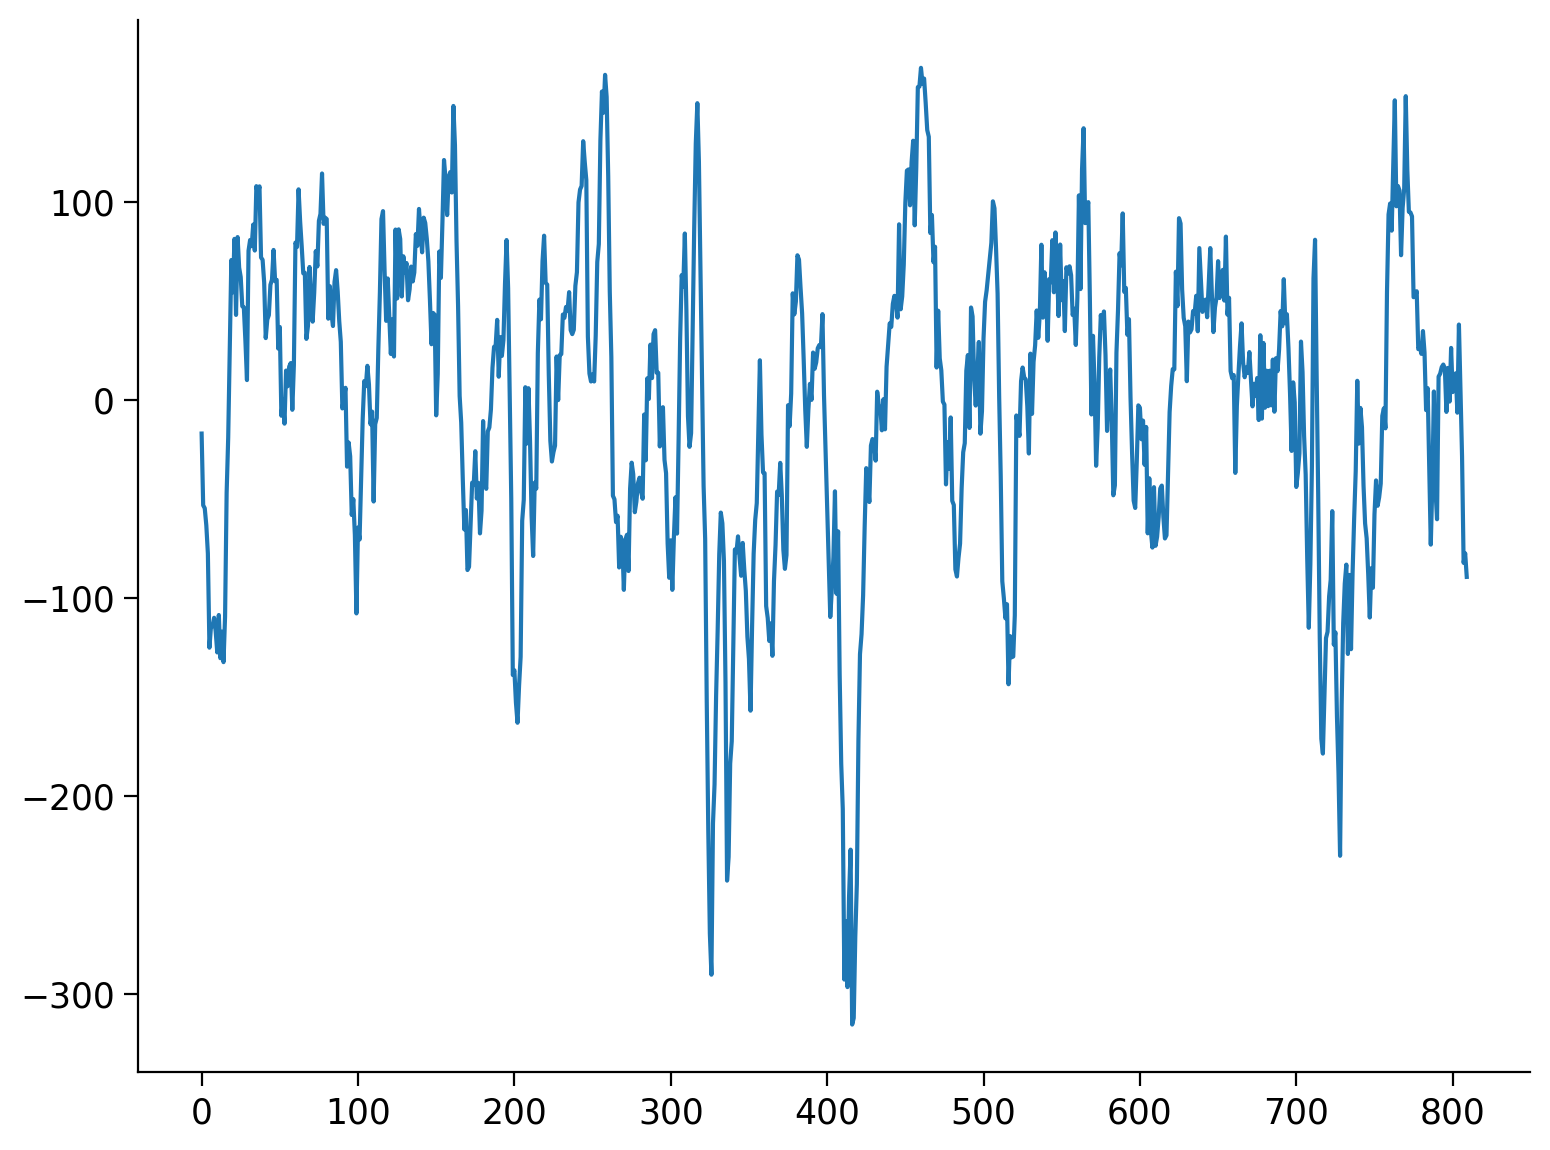

In [ ]:
plt.plot(ts0[0, :])

In [ ]:
# curious about a fun? use help()
help(load_timeseries)


Help on function load_timeseries in module __main__:

load_timeseries(subject, name, dir, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      dir (str) : data directory
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



## Concatenate conditions

This can be used to concatenate any number of conditions within any task. Just provide a list of all conditions you wanna concat and task id.

In [ ]:
help(get_conds)

Help on function get_conds in module __main__:

get_conds(subject, task, conds, concat=False, skip=0)
    Get timeseries for conditions of interest.
    Args:
    subject (int): subject id,
    task (string): task id ("wm", "gambling" etc.)
    conds (list): list of conditions to concatenate.
    concat (bool): If true, concatenate conditions instead of making a list.
    skip (int):  Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    Returns:
    ndarray (n_parcel x n_tp array) or list of ndarrays: Array of concatenated BOLD data values or a list of (not concatenated) data values.



In [ ]:
# list all 2-back conditions
two_back_conds = ['2bk_body', '2bk_faces', '2bk_places', '2bk_tools']

# list all 0-back conditions
no_back_conds = ['0bk_body', '0bk_faces', '0bk_places', '0bk_tools']

two_back, no_back = [], []
for s in subjects:
  two_back.append(get_conds(s, "wm", two_back_conds, concat=True))
  no_back.append(get_conds(s, "wm", no_back_conds, concat=True))

print(two_back[0].shape)

(360, 312)


## Extract FPN timeseries

In [ ]:
## Use the extract_frontoparietal_parcels function
help(extract_frontoparietal_parcels)

Help on function extract_frontoparietal_parcels in module __main__:

extract_frontoparietal_parcels(two_back, no_back, region_info)
    Extracts the Frontoparietal network parcels from two_back and no_back datasets.
    
    Parameters:
    - two_back: List of NumPy arrays, each representing the time series data for a participant
                during the two-back task with shape (regions:360, subjects:399).
    - no_back: List of NumPy arrays, each representing the time series data for a participant
                during the no-back task with shape (regions:360, subjects:399).
    - region_info: A dictionary containing region metadata, including network assignments.
    
    Returns:
    - two_back_fpn: List of NumPy arrays containing only the Frontoparietal network parcels
                     from the two_back dataset. (subjetcs: 339, parcels: 50, timepoints:152)
    - no_back_fpn: List of NumPy arrays containing only the Frontoparietal network parcels
                    from the

In [ ]:
## Uses the extract_frontoparietal_parcels to extract timeseries of parcels belonging to FPN
two_back_fpn, no_back_fpn = extract_frontoparietal_parcels(two_back, no_back, region_info)


## Get condition onsets & timeseries

In [ ]:
help(get_cond_onsets)

Help on function get_cond_onsets in module __main__:

get_cond_onsets(num_subjects, conditions, fpath_task)
    Extracts the onsets of each condition of each subject
    
    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - fpath_task: path to the event info
    
    Returns:
    - Onsets: pandas dataframe containing the onset time per condition,
        separated for each run (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.))



In [ ]:
help(get_cond_timeseries)

Help on function get_cond_timeseries in module __main__:

get_cond_timeseries(num_subjects, conditions, fpath_task, Onsets)
    Extracts the timeseries of each condition of each subject (360 ROI * 38 or 39 timepoints)
    
    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - fpath_task: path to the event info
    
    Returns:
    - TimeSeries: pandas dataframe containing the timeseries per condition, separated for each run
        (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.)),
        each cell of the pd dataframe contains the timeseries of all 360 ROIs



In [ ]:
# Get condition onsets
conditions=['2bk_body', '2bk_faces', '2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
num_subjects = 339

Onsets = get_cond_onsets(num_subjects,conditions,fpath_task)

print(Onsets.head())

   2bk_body_run0  2bk_body_run1  2bk_faces_run0  2bk_faces_run1  \
0          7.997        150.593         178.794          79.275   
1          7.996        150.806         179.021          79.355   
2          7.997        150.538         178.767          79.234   
3          7.997        150.514         178.783          79.209   
4          7.997        150.966         179.141          79.434   

   2bk_places_run0  2bk_places_run1  2bk_tools_run0  2bk_tools_run1  \
0          250.219          178.755          79.368           7.997   
1          250.499          178.968          79.434           7.997   
2          250.071          178.646          79.368           7.997   
3          250.088          178.596          79.369           7.997   
4          250.712          179.141          79.488           7.997   

   0bk_body_run0  0bk_body_run1  0bk_faces_run0  0bk_faces_run1  \
0        107.463         36.146          36.159         222.057   
1        107.650         36.226     

In [ ]:
# Get events timeseries
conditions=['2bk_body', '2bk_faces', '2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
num_subjects = 339
TimeSeries = get_cond_timeseries(num_subjects,conditions,fpath_task,Onsets)

print(TimeSeries.shape) # 339 * 16
print(TimeSeries.index) # rows=339 subjects
print(TimeSeries.columns) # columns=8 conditions in 2 runs
print(TimeSeries.iloc[0,0]) # 360 ROIs * (38 or 39) slices

(339, 16)
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '329', '330', '331', '332', '333', '334', '335', '336', '337', '338'],
      dtype='object', length=339)
Index(['2bk_body_run0', '2bk_body_run1', '2bk_faces_run0', '2bk_faces_run1',
       '2bk_places_run0', '2bk_places_run1', '2bk_tools_run0',
       '2bk_tools_run1', '0bk_body_run0', '0bk_body_run1', '0bk_faces_run0',
       '0bk_faces_run1', '0bk_places_run0', '0bk_places_run1',
       '0bk_tools_run0', '0bk_tools_run1'],
      dtype='object')
              0           1           2           3           4           5  \
0   -108.519012 -130.319012 -116.919012 -132.319012 -109.219012  -46.819012   
1     113.20716    69.80716   125.60716   126.00716   142.40716    47.40716   
2     49.633827   58.733827   21.133827    0.333827   -1.166173   84.333827   
3    -56.068395  -54.068395  -22.168395  -63.668395  -67.568395  -38.068395   
4    -51.088148  -77.288148  -37.788148  -53.788148  -79.688148  -33.

## BOLD signal variability

BOLD signal variability refers to the fluctuations in the blood oxygen level-dependent (BOLD) signal measured during functional magnetic resonance imaging (fMRI) experiments. It represents the moment-to-moment changes in brain activity rather than just the average or mean activity levels typically analyzed in fMRI studies. This is typically calculated as the standard deviation (SD) or entropy measures such as multiscale entropy (MSE) of the BOLD signal over time for each voxel or region of interest.

**Key references**

Whats the meaning of BOLD variavility?
https://doi.org/10.1016/j.neuron.2021.01.023

Using SD as a measure of BOLD variability
https://doi.org/10.1016/j.neuroimage.2019.116373


Using BOLD brain signal variability in task data:
https://doi.org/10.1016/j.neuroimage.2017.12.031


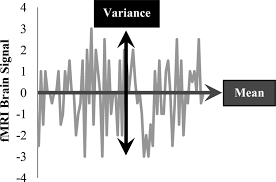

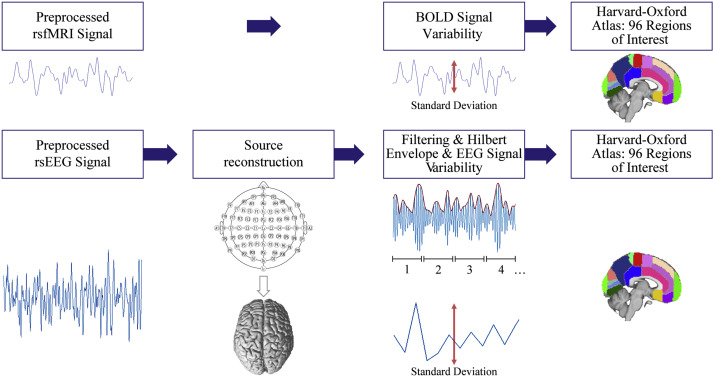

### SD BOLD (whole-brain)

NOTE: here we might need to do some pre-processing steps

e.g., "normalize all
blocks for each condition such that the overall 4D mean across brain and
block was 100"

In [ ]:
## Compute SD per condition per participant

# Initialize lists to store standard deviations
SD_two_back = []
SD_no_back = []

for s in subjects:
    # Compute the standard deviation for each condition
    sd_two_back = np.std(two_back, axis=2)  # axis=2 computes SD across time points
    sd_no_back = np.std(no_back, axis=2)  # axis=2 computes SD across time points

    # Append the results to the respective lists
    SD_two_back.append(sd_two_back)
    SD_no_back.append(sd_no_back)

# Print shapes of the first elements in the lists to verify
print(SD_two_back[0].shape)
print(SD_no_back[0].shape)

# The shape


(339, 360)
(339, 360)


### SD BOLD (FPN only)

In [ ]:
# Calculate the standard deviation for Frontoparietal parcels across time points
SD_two_back_fpn = np.std(two_back_fpn, axis=2)
SD_no_back_fpn = np.std(no_back_fpn, axis=2)

# Print shapes to verify
print("SD_two_back_fpn shape:", SD_two_back_fpn.shape)  # Shape should be (339, 50)
print("SD_no_back_fpn shape:", SD_no_back_fpn.shape)    # Shape should be (339, 50)

# For every participant (399) there are 50 brain regions with a SD

SD_two_back_fpn shape: (339, 50)
SD_no_back_fpn shape: (339, 50)


In [ ]:
## Average SD BOLD for all parcels of the FPN

# Calculate the mean SD across parcels for each participant
average_SD_two_back_fpn = np.mean(SD_two_back_fpn, axis=1)  # Shape will be (399,)
average_SD_no_back_fpn = np.mean(SD_no_back_fpn, axis=1)    # Shape will be (399,)
print(average_SD_no_back_fpn.shape)

 # For every participant (399) there is 1 average SD


(339,)


In [ ]:
# check shapes
pd.DataFrame({
    'subject': np.arange(339),
    'two_back':average_SD_two_back_fpn,
    'no_back': average_SD_no_back_fpn,
}).to_csv('sd_bold_fpn_only.csv')



## Visulize the FPN SD

Scatter plot average_SD_two_back_fpn in term of average_SD_two_back_fpn

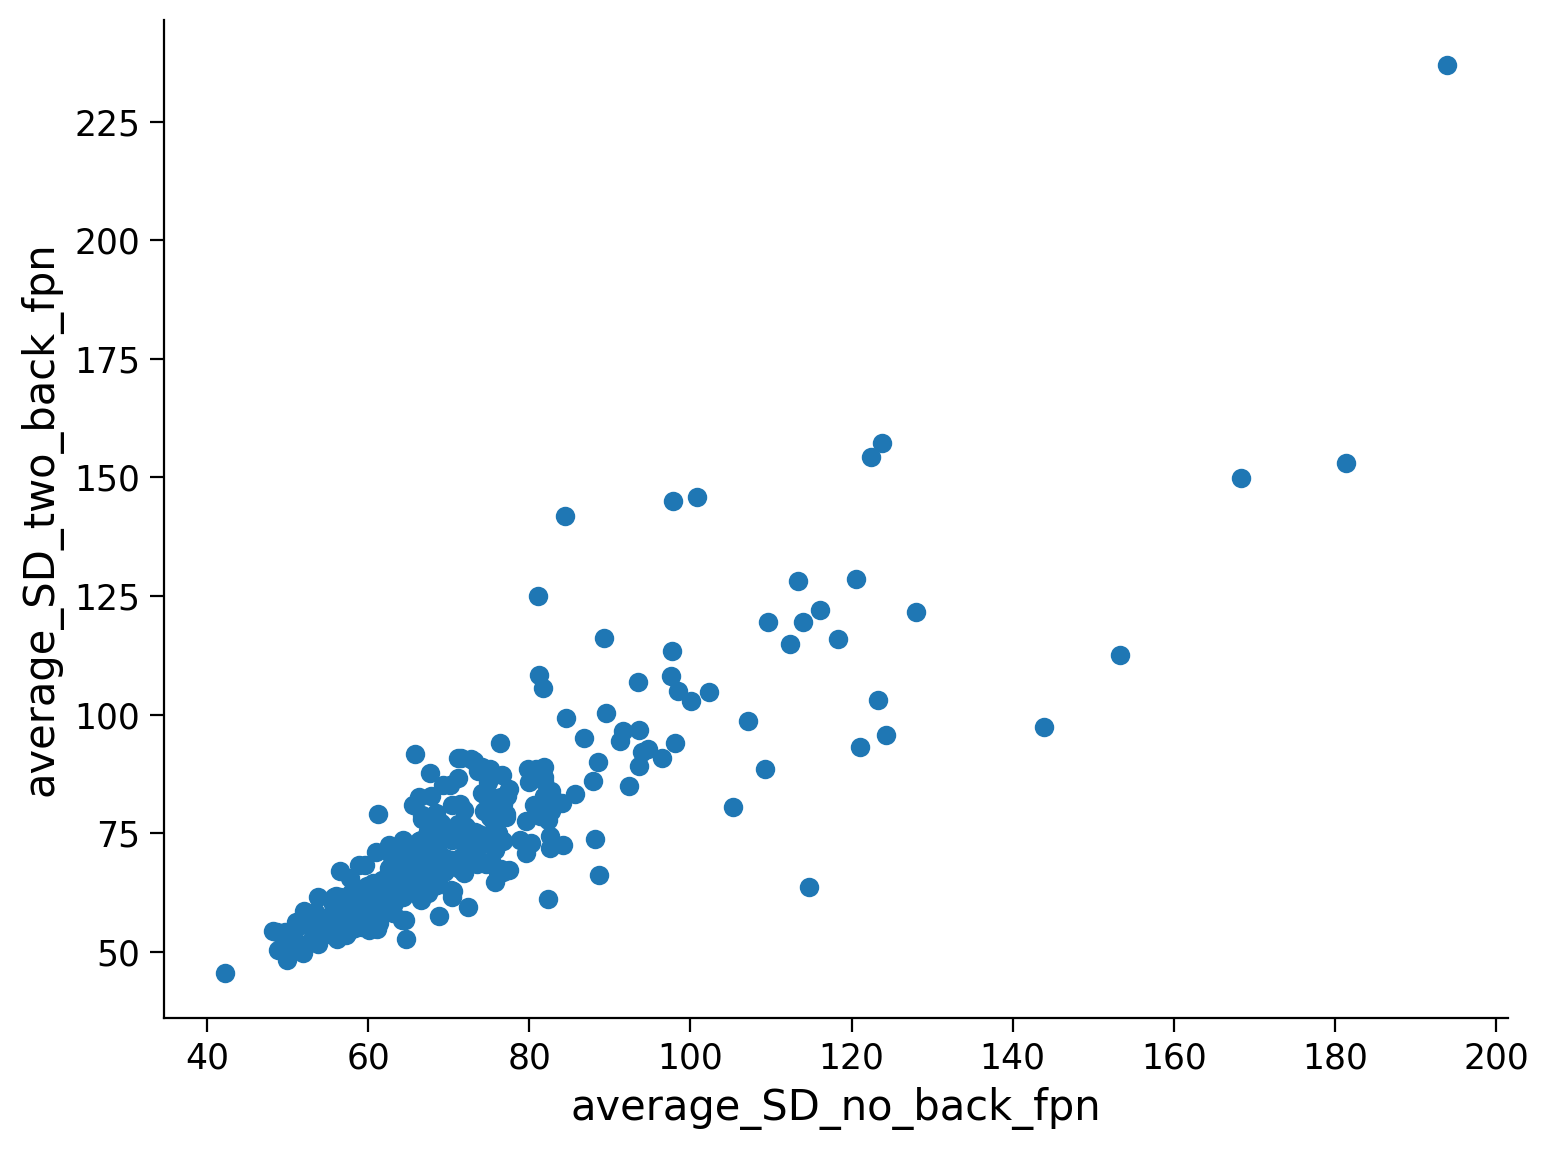

In [ ]:
plt.scatter(average_SD_no_back_fpn, average_SD_two_back_fpn)
plt.xlabel("average_SD_no_back_fpn")
plt.ylabel("average_SD_two_back_fpn")
plt.show()

Histogram of average_SD_no_back_fpn and average_SD_two_back_fpn

array([[<Axes: title={'center': '0'}>]], dtype=object)

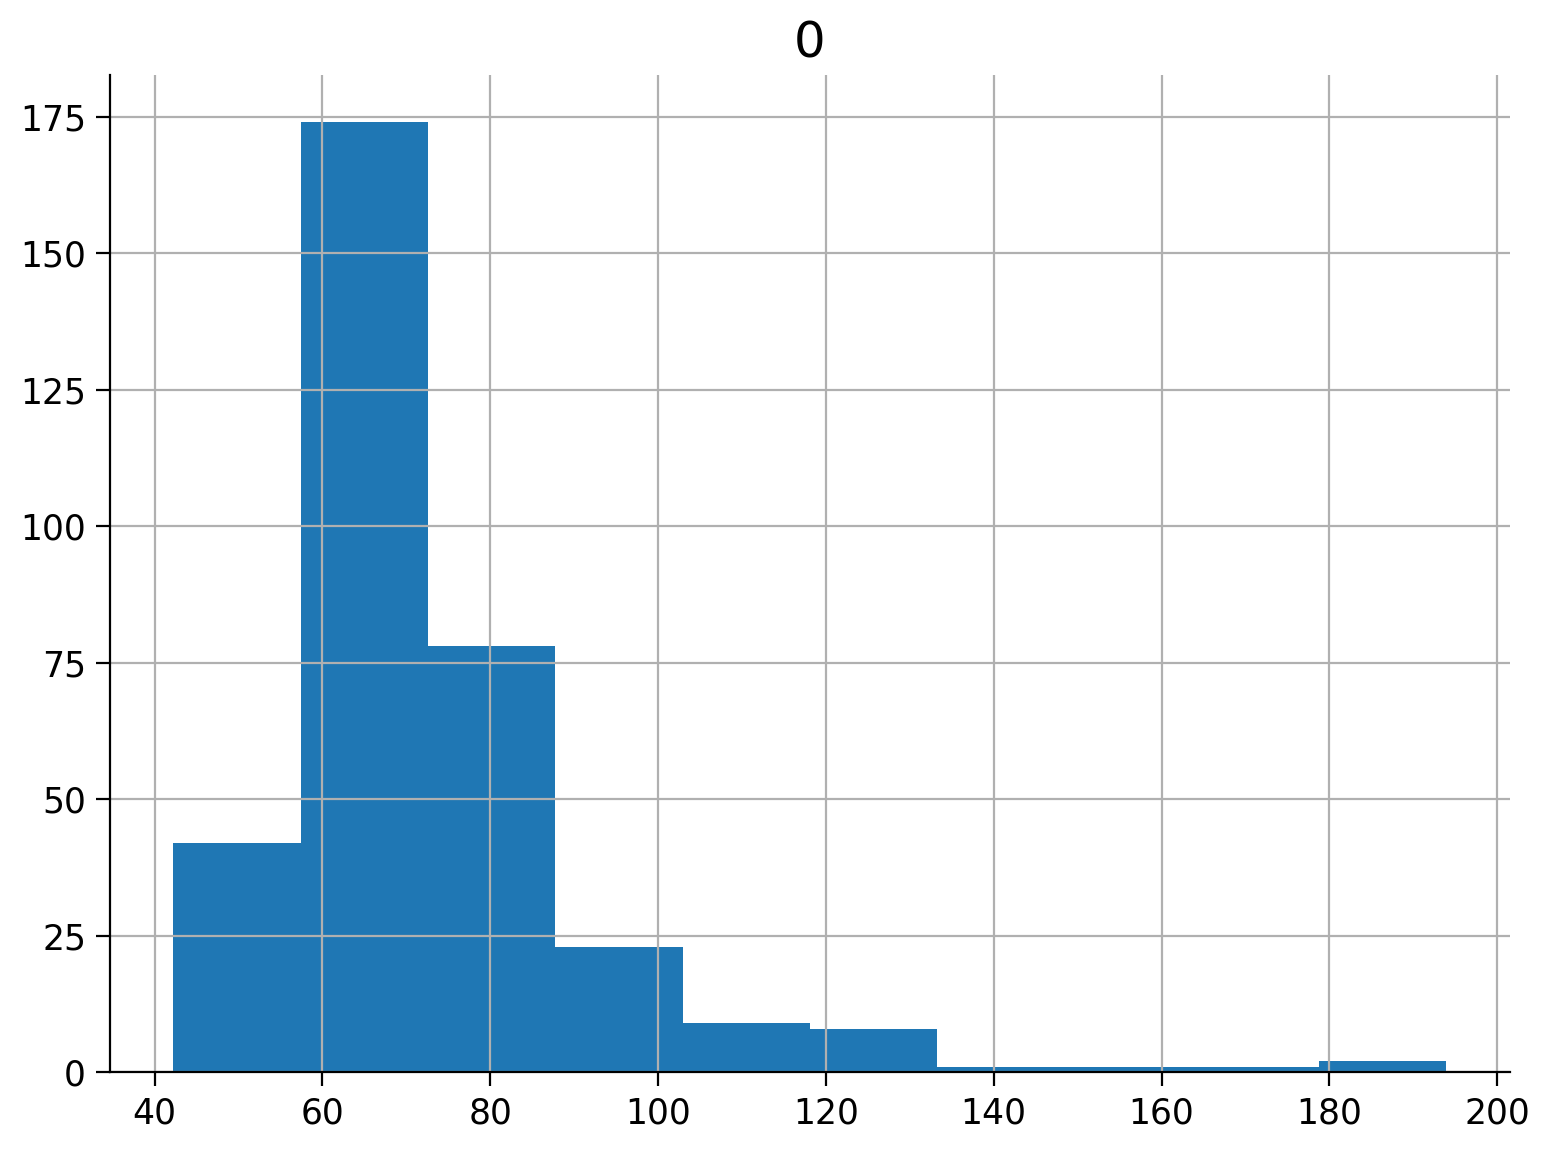

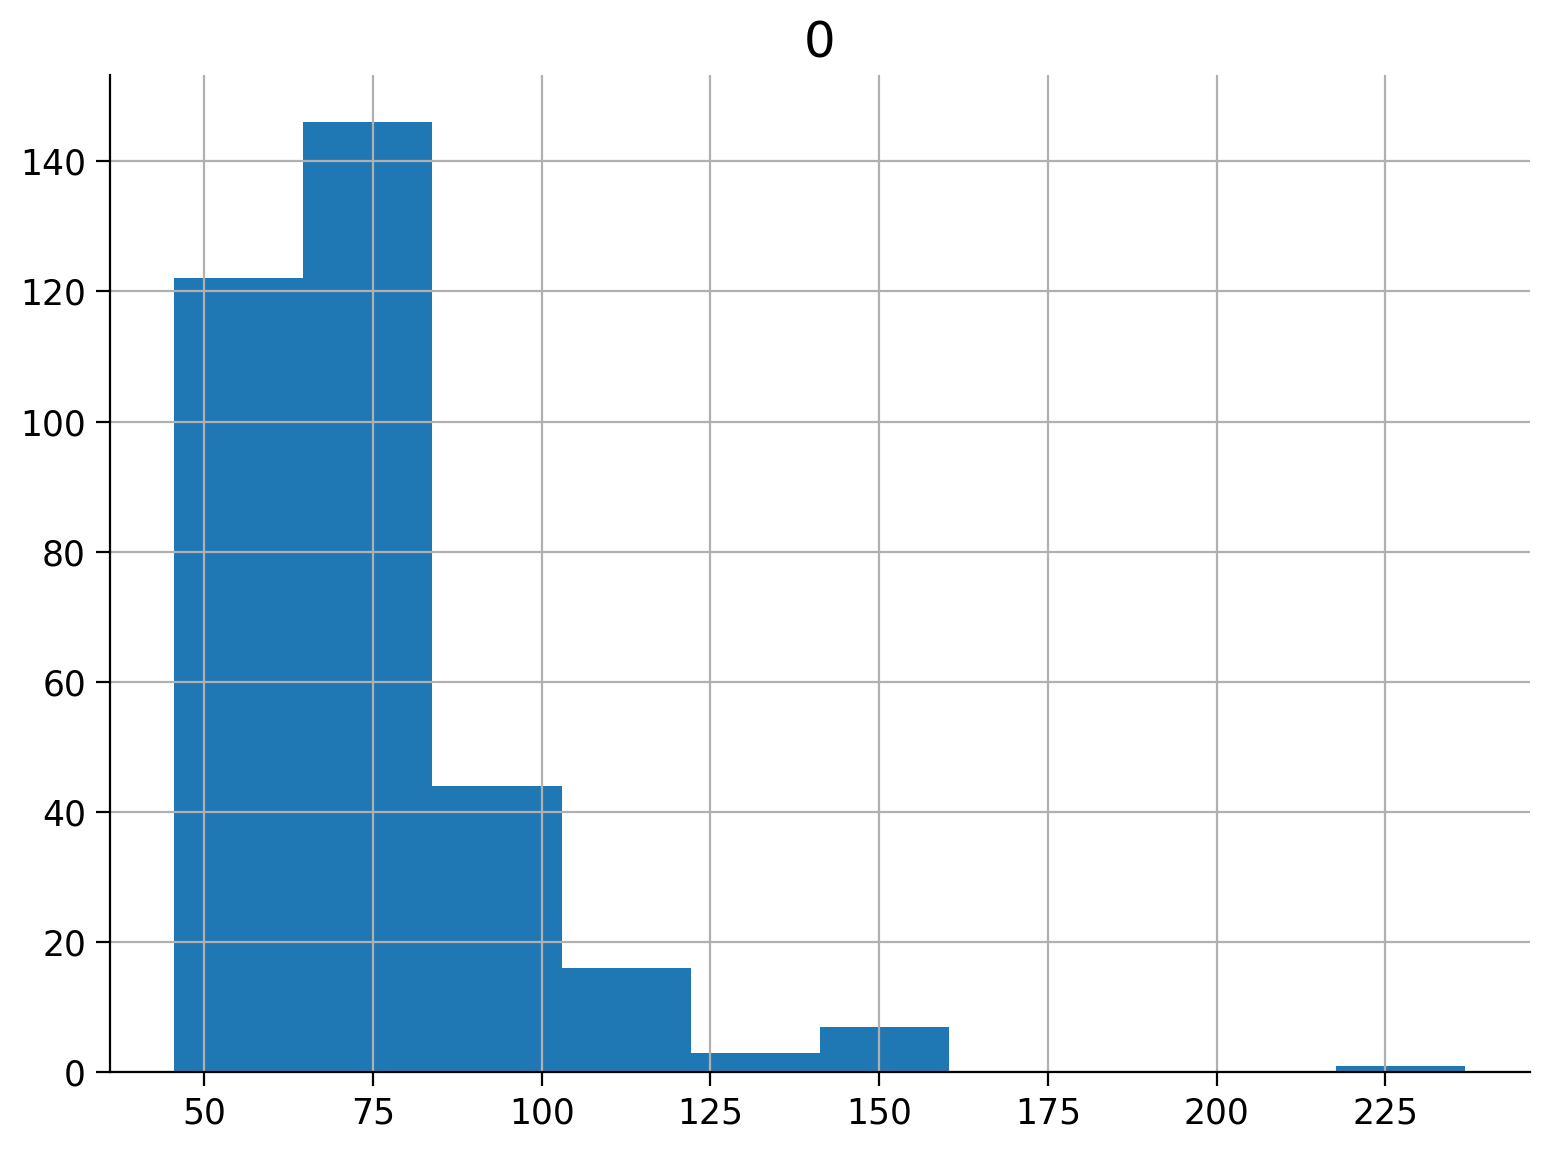

In [ ]:
pd.DataFrame(average_SD_no_back_fpn).hist()
pd.DataFrame(average_SD_two_back_fpn).hist()

## SVM on FPN SD

Make features_array (number of subject x number of FPN Parcels) and label vector

In [ ]:
# Make features_array by concatinating of SD_no_back_fpn and SD_two_back_fpn
features_array = np.concatenate((SD_no_back_fpn, SD_two_back_fpn),axis = 0)
# Make label_array
label_array = np.zeros(features_array.shape[0])
label_array[0:339] = 0
label_array[339:678] = 1

Split data into train and test data and data normalization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate

X_train, X_test, y_train, y_test = train_test_split(features_array,label_array,test_size=0.2,random_state=50)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [ ]:
print(X_train.shape, X_test.shape)

(542, 50)

Implementation of SVM on FPN SD

0.6309963099630996


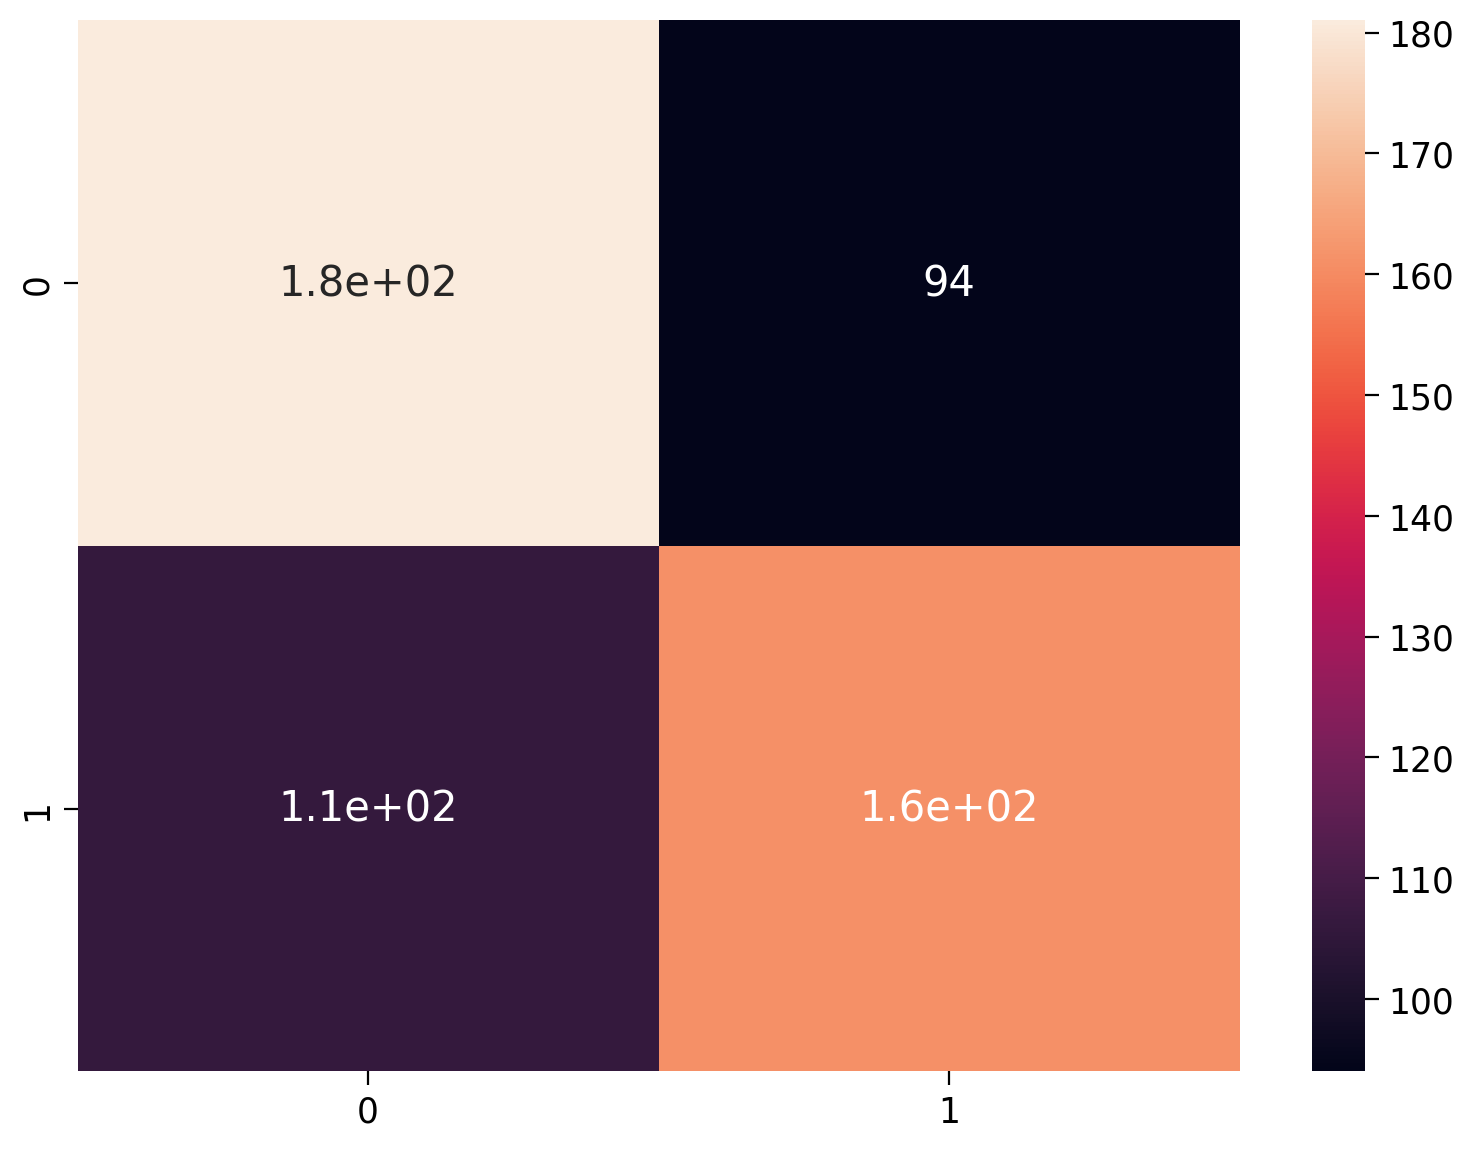

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
import seaborn as sns
clf = SVC(C = 0.5,kernel = 'linear')
clf.fit(X_train,y_train)
y_predict = clf.predict(X_train)
cm = confusion_matrix(y_train,y_predict)
sns.heatmap(cm,annot = True)
print(accuracy_score(y_train,y_predict))

Confusion matrix for test data

0.5735294117647058


<Axes: >

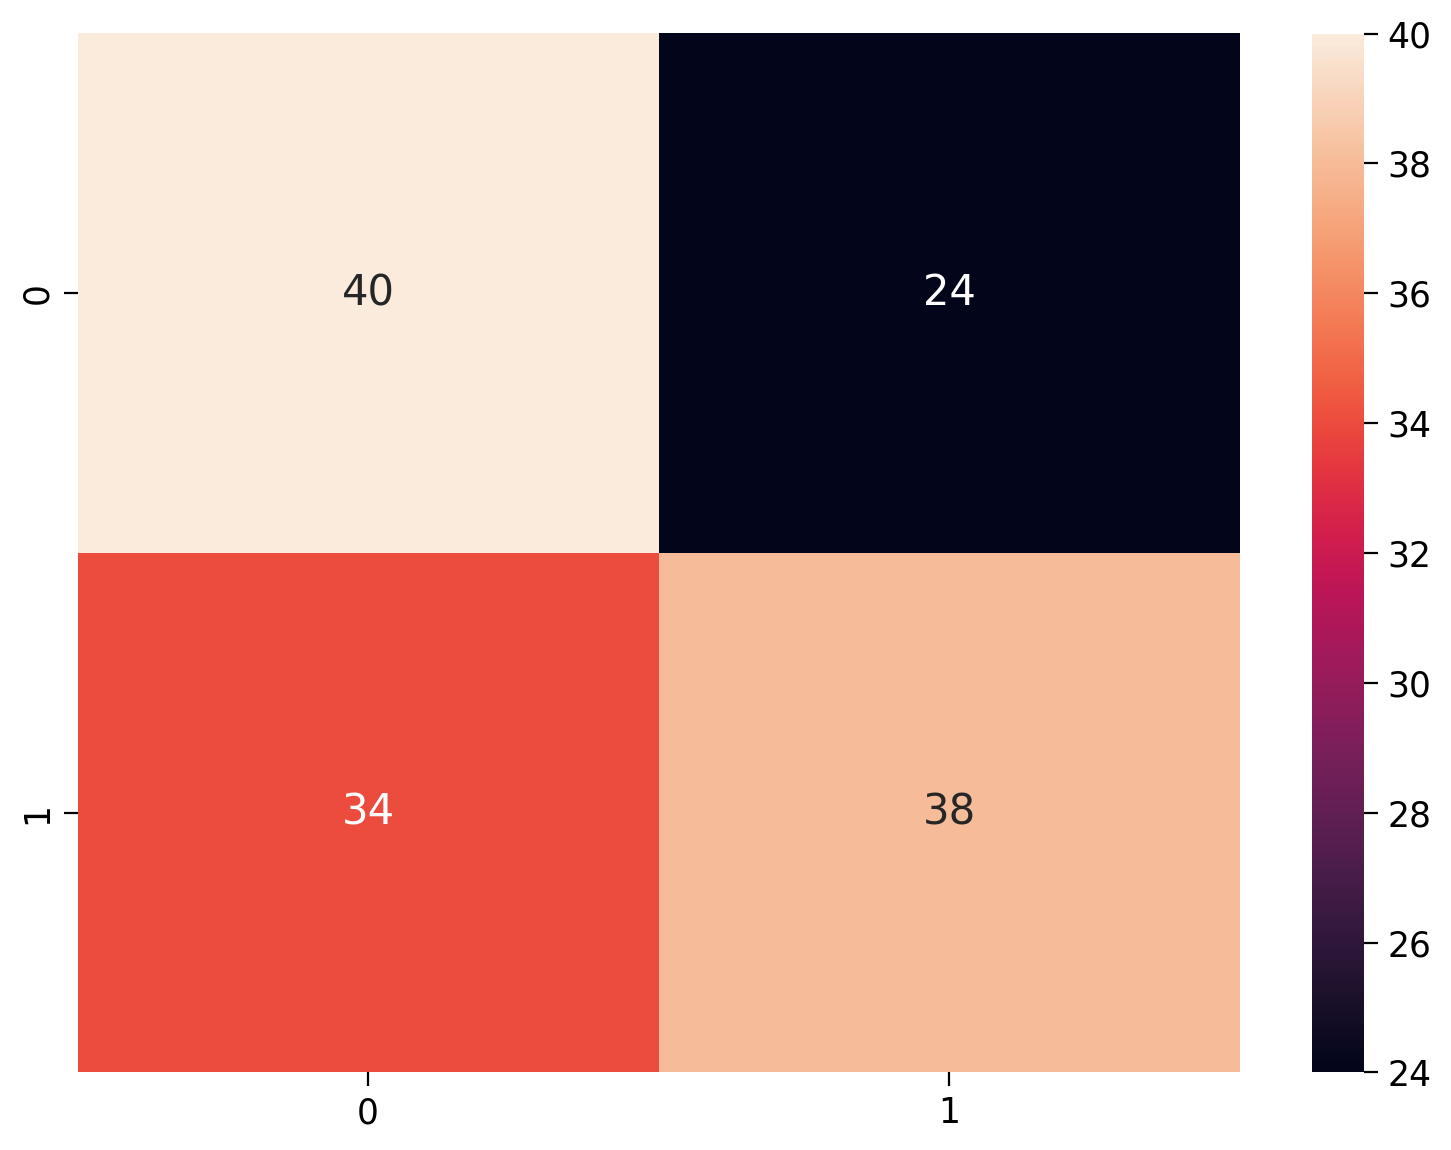

In [ ]:
y_predict = clf.predict(X_test)
print(accuracy_score(y_test,y_predict))
cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm,annot = True)

## SVM on MMSE data

Read data

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/MMSE.csv')

In [ ]:
import numpy as np

In [ ]:
X = np.array(df["mmse"])

In [ ]:
df

,id,subject,condition,scale,mmse
0,0,0,two_back,0,0.003690
1,1,0,two_back,1,0.005728
2,2,0,two_back,2,0.009555
3,3,0,two_back,3,0.013500
4,4,0,two_back,4,0.017007
...,...,...,...,...,...
5419,3,338,no_back,3,0.010271
5420,4,338,no_back,4,0.014851
5421,5,338,no_back,5,0.016846
5422,6,338,no_back,6,0.017222


Make features_array (Number of subject x order of MMSE)

In [ ]:
features_array = X.reshape((-1,8))

In [ ]:
features_array.shape

(678, 8)

Make label vector

In [ ]:
y = np.array(df['condition'])

In [ ]:
label_array = y.reshape((-1,8))[:,0]

In [ ]:
label_array.shape

(678,)

Split data into train and test and data normalization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate

X_train, X_test, y_train, y_test = train_test_split(features_array,label_array,test_size=0.2,random_state=50)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

Implementation of SVM on MMSE

0.6678966789667896


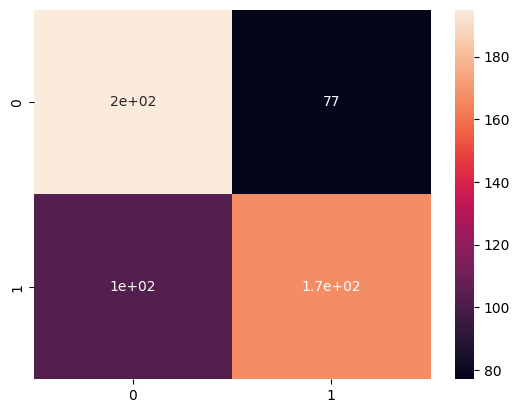

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
import seaborn as sns
clf = SVC(C = 0.5,kernel = 'linear')
clf.fit(X_train,y_train)
y_predict = clf.predict(X_train)
cm = confusion_matrix(y_train,y_predict)
sns.heatmap(cm,annot = True)
print(accuracy_score(y_train,y_predict))

Confusion matrix for test data

0.6544117647058824


<Axes: >

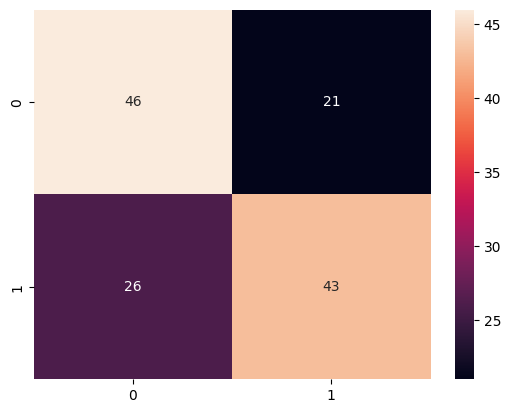

In [ ]:
y_predict = clf.predict(X_test)
print(accuracy_score(y_test,y_predict))
cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm,annot = True)